In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 140266565.15it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107010330.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42567714.24it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3410406.15it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Part 1

## network architecture

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_dim, h1, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, h1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(h1, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## train loop

In [ ]:
def train(train_loader, val_loader, model, loss_fn, optimizer, epochs=10):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):

        train_loss = 0
        train_acc = 0

        # train mode
        model.train()
        # iterate through batches
        for b, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the grads
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # find predictions for calculating accuracy
            preds = torch.argmax(outputs, dim=1)
            # calculate loss
            loss = loss_fn(outputs, labels)
            # backpropagation
            loss.backward()
            # update parameters
            optimizer.step()

            train_loss += loss.item()
            train_acc += torch.sum(labels == preds).item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)

        # val mode
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for b, data in enumerate(val_loader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                val_acc += torch.sum(labels == preds).item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'epoch {epoch}: train loss: {train_loss:.4f}, val loss: {val_loss:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

## train the model

In [ ]:
mlp = MLP(28*28, 128, 10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

train_losses, val_losses, train_accuracies, val_accuracies = train(train_loader, val_loader, mlp, loss_fn, optimizer, 10)

epoch 0: train loss: 0.6577, val loss: 0.3820
epoch 1: train loss: 0.3344, val loss: 0.3176
epoch 2: train loss: 0.2862, val loss: 0.2790
epoch 3: train loss: 0.2530, val loss: 0.2469
epoch 4: train loss: 0.2248, val loss: 0.2261
epoch 5: train loss: 0.2018, val loss: 0.1973
epoch 6: train loss: 0.1820, val loss: 0.1855
epoch 7: train loss: 0.1653, val loss: 0.1743
epoch 8: train loss: 0.1507, val loss: 0.1613
epoch 9: train loss: 0.1391, val loss: 0.1494


## plot learning curve

Text(0, 0.5, 'Loss')

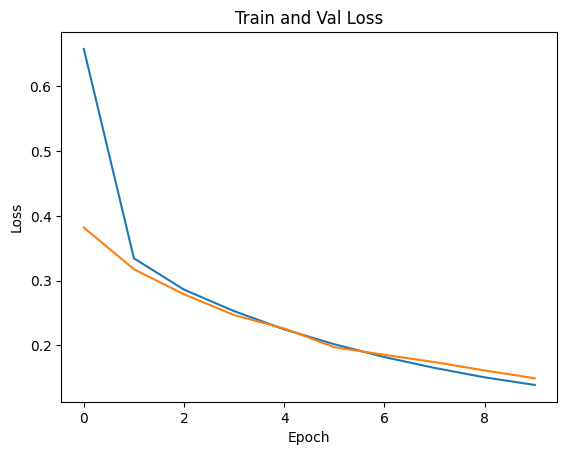

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

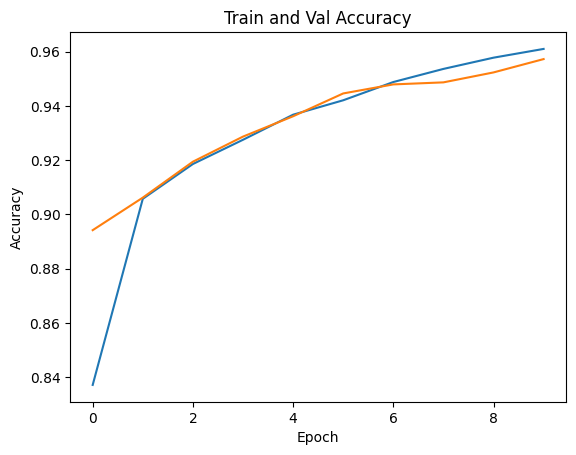

In [ ]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Train and Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## test set

In [ ]:
from sklearn.metrics import confusion_matrix

def test(test_loader, model):
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for b, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    return all_labels, all_predictions

In [ ]:
all_labels, all_predictions = test(test_loader, mlp)
test_acc = (np.array(all_labels) == np.array(all_predictions)).sum() / len(all_labels)

print("test accuracy:", test_acc)
print(confusion_matrix(all_labels, all_predictions))

test accuracy: 0.9577
[[ 962    0    1    1    0    4    8    2    2    0]
 [   0 1119    2    2    0    1    5    2    4    0]
 [   5    5  978   11    3    1    6   10   12    1]
 [   1    2    4  976    0    4    2    8    7    6]
 [   1    1    4    0  926    0   10    3    2   35]
 [   7    2    1   24    1  825   12    1   12    7]
 [   6    3    0    1    5    7  931    0    5    0]
 [   2    8   12    6    1    1    0  982    1   15]
 [   4    2    3   16    6    4   10    9  915    5]
 [   4    6    1   12    9    1    2   10    1  963]]


# Part 2

## network architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

## train the model

In [ ]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = train(train_loader, val_loader, cnn, loss_fn, optimizer, 10)

epoch 0: train loss: 0.1470, val loss: 0.0595
epoch 1: train loss: 0.0499, val loss: 0.0454
epoch 2: train loss: 0.0357, val loss: 0.0464
epoch 3: train loss: 0.0261, val loss: 0.0457
epoch 4: train loss: 0.0219, val loss: 0.0476
epoch 5: train loss: 0.0152, val loss: 0.0523
epoch 6: train loss: 0.0137, val loss: 0.0537
epoch 7: train loss: 0.0111, val loss: 0.0523
epoch 8: train loss: 0.0092, val loss: 0.0497
epoch 9: train loss: 0.0082, val loss: 0.0569


## plot learning curve

Text(0, 0.5, 'Loss')

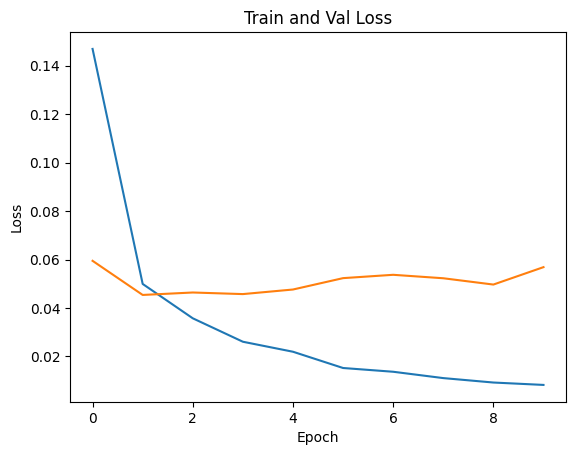

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

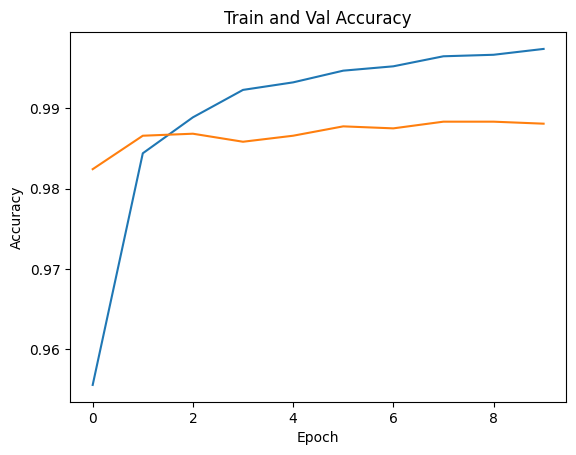

In [ ]:
plt.plot(cnn_train_accuracies, label='Train Accuracy')
plt.plot(cnn_val_accuracies, label='Val Accuracy')
plt.title('Train and Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## test set

In [ ]:
cnn_all_labels, cnn_all_predictions = test(test_loader, cnn)
cnn_test_acc = (np.array(cnn_all_labels) == np.array(cnn_all_predictions)).sum() / len(cnn_all_labels)

print("test accuracy:", cnn_test_acc)
print(confusion_matrix(cnn_all_labels, cnn_all_predictions))

test accuracy: 0.989
[[ 975    0    1    0    0    0    0    1    3    0]
 [   0 1130    2    0    0    0    1    1    1    0]
 [   0    0 1029    0    0    0    0    2    1    0]
 [   0    1    4 1001    0    4    0    0    0    0]
 [   0    0    1    0  975    0    0    0    1    5]
 [   0    1    0    5    0  882    3    0    1    0]
 [   3    1    1    0    2    2  946    0    3    0]
 [   0    4   20    0    0    0    0 1002    1    1]
 [   3    1    3    0    1    0    0    0  965    1]
 [   0    0    0    0   11    7    0    3    3  985]]


# Part 3

## resize data and increase channels

In [ ]:
# in order to use mobilenet, should increase channels from 1 to 3
# and resize to 224*224
transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32
dataset2 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform2)
train_set2, val_set2 = torch.utils.data.random_split(dataset2, [0.8, 0.2])

train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=batch_size, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(val_set2, batch_size=batch_size, shuffle=False)

test_set2 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform2)
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 233366887.70it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 98805623.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 99009196.67it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19518984.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## mobilenet model

In [ ]:
from torchvision.models.mobilenet import mobilenet_v2

mobilenet_model = mobilenet_v2(pretrained=True)
print(mobilenet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# change the number of neurons of output layer for our dataset
mobilenet_model.classifier[1] = nn.Linear(in_features=1280, out_features=10)

# freeze other layers
for param in mobilenet_model.features.parameters():
    param.requires_grad = False

mobilenet_model = mobilenet_model.to(device)

## train the model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr=0.001)

mobilenet_train_losses, mobilenet_val_losses, mobilenet_train_accuracies, mobilenet_val_accuracies = train(train_loader2, val_loader2, mobilenet_model, loss_fn, optimizer, 10)

epoch 0: train loss: 0.3767, val loss: 0.1836
epoch 1: train loss: 0.2187, val loss: 0.1603
epoch 2: train loss: 0.1988, val loss: 0.1412
epoch 3: train loss: 0.1903, val loss: 0.1319
epoch 4: train loss: 0.1784, val loss: 0.1345
epoch 5: train loss: 0.1787, val loss: 0.1292
epoch 6: train loss: 0.1748, val loss: 0.1189
epoch 7: train loss: 0.1757, val loss: 0.1277
epoch 8: train loss: 0.1746, val loss: 0.1133
epoch 9: train loss: 0.1728, val loss: 0.1299


## plot learning curve

Text(0, 0.5, 'Loss')

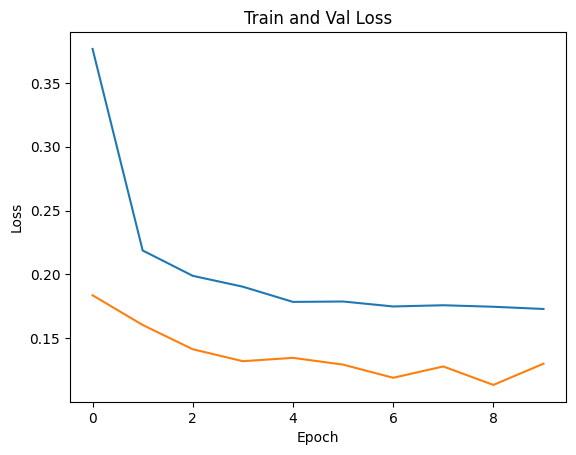

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mobilenet_train_losses, label='Train Loss')
plt.plot(mobilenet_val_losses, label='Val Loss')
plt.title('Train and Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

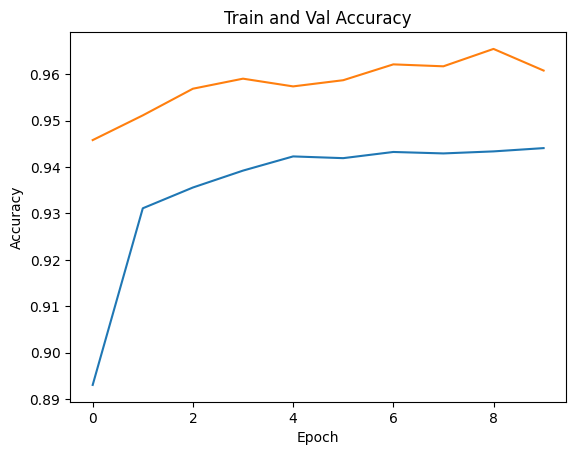

In [ ]:
plt.plot(mobilenet_train_accuracies, label='Train Accuracy')
plt.plot(mobilenet_val_accuracies, label='Val Accuracy')
plt.title('Train and Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## test set

In [ ]:
mobilenet_all_labels, mobilenet_all_predictions = test(test_loader2, mobilenet_model)
mobilenet_test_acc = (np.array(mobilenet_all_labels) == np.array(mobilenet_all_predictions)).sum() / len(mobilenet_all_labels)

print("test accuracy:", mobilenet_test_acc)
print(confusion_matrix(mobilenet_all_labels, mobilenet_all_predictions))

test accuracy: 0.9624
[[ 957    0    1    1    4    5    6    1    1    4]
 [   0 1133    1    0    1    0    0    0    0    0]
 [   5    9  935   24    9   21    5   13    5    6]
 [   0    0    1  991    1   13    0    1    0    3]
 [   0    5    0    0  967    0    4    0    1    5]
 [   1    0    0   30    1  853    1    4    1    1]
 [   8    8    1    1    7    8  923    0    1    1]
 [   0   19    3    5   12    1    0  973    0   15]
 [   6    1    2    5    6    6    8    1  923   16]
 [   6    4    0    5    9    9    0    5    2  969]]
